# Open the Readme file for instructions on how to run the code

In token_path, img_path, train_path, test_path variable add the path of *Flickr8k.token.txt*, *Flicker8k_Dataset*, *Flickr_8k.trainImages.txt* &*Flickr_8k.testImages.txt* file respectively 

In [ ]:
token_path = '/content/drive/MyDrive/DS303/Flickr8k.token.txt'
img_path   = '/content/drive/MyDrive/DS303/Flicker8k_Dataset/'
train_path = '/content/drive/MyDrive/DS303/Flickr_8k.trainImages.txt'
test_path  = '/content/drive/MyDrive/DS303/Flickr_8k.testImages.txt'
glove_path =  '/content/drive/MyDrive/DS303/glove.6B.200d.txt'

## Importing Libraries

In [ ]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline

import string
import os
import glob
from PIL import Image
from time import time

from keras import Input, layers
from keras import optimizers
from keras.optimizers import Adam
from keras.preprocessing import sequence
from keras.preprocessing import image
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_v3 import preprocess_input
from keras.models import Model
from keras.utils import to_categorical

## Mapping image and description

In [ ]:
text = open(token_path, 'r', encoding = 'utf-8').read()  

# we will write a function mapping to map image id with caption

def mapping(text):
    captions=dict()
    for line in text.split("\n"):
        token = line.split("\t")
        if len(line) < 2:                 # remove short descriptions
            continue
        img_id = token[0].split('.')[0]   # name of the image
        img_des = token[1]                # description of the image
        if img_id not in captions:
            captions[img_id] = list()
        captions[img_id].append(img_des)
    return captions

img_captions=mapping(text)


## Function to show demo caption

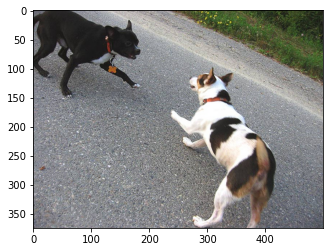

Caption-> A black dog and a spotted dog are fighting
Caption-> A black dog and a tri-colored dog playing with each other on the road .
Caption-> A black dog and a white dog with brown spots are staring at each other in the street .
Caption-> Two dogs of different breeds looking at each other on the road .
Caption-> Two dogs on pavement moving toward each other .


In [ ]:
def show_caption(img_id,captions):
    x=plt.imread(img_path+img_id+'.jpg')
    plt.imshow(x)
    plt.show()
    cap_number=1
    for line in captions[img_id]:
        print("Caption->",line)
        
show_caption('1001773457_577c3a7d70',img_captions)

## Data Cleaning

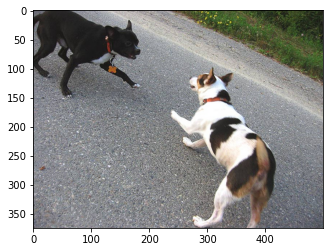

Caption-> a black dog and a spotted dog are fighting
Caption-> a black dog and a tricolored dog playing with each other on the road
Caption-> a black dog and a white dog with brown spots are staring at each other in the street
Caption-> two dogs of different breeds looking at each other on the road
Caption-> two dogs on pavement moving toward each other


In [ ]:
def caption_cleaning(img_captions):                        #function takes in dictionary of captions and returns cleaned version
    
    translator = str.maketrans('', '', string.punctuation) #helps in removing punctuation
    
    for img_id,cap_list in img_captions.items():           #image id and caption list for each image
        
        for i in range(len(cap_list)):                     # i goes from 0 to 4 (i.e 5 captions for each img_id)
            
            caption=cap_list[i]
            
            caption.replace("-"," ")                        #Removes '-' symbol from caption
            
            caption = caption.split()                       #splits caption into words
            
            caption = [word.lower() for word in caption ]   #converts to lowercase
             
            caption = [word.translate(translator) for word in caption] #remove punctuation
            
            
            caption = [word for word in caption if(word.isalpha())] #remove words if they have numbers
            
            
            caption = ' '.join(caption)  #convert back to string
            
            cap_list[i] = caption #adds cleaned caption back to dictionary


caption_cleaning(img_captions)       

show_caption('1001773457_577c3a7d70',img_captions)   # function to show image with its new cleaned captions
            
      

## Making the Vocabulary

In [ ]:
def caption_vocabulary(img_captions):  #function will create vocabulary from captions
    
    vocab=set()                        # creating a set so that we only store unique words
    
    for key in img_captions.keys():
        
        for line in img_captions[key]:     
            
            vocab.update(line.split())  #updating the set with a new word
    
    return vocab

vocab = caption_vocabulary(img_captions)

print("The number of unique words in our vocabulary are :" , len(vocab)) #prints the number of words vocabulary
    


The number of unique words in our vocabulary are : 8775


In [ ]:
lines = list()
for img_id,cap_list in img_captions.items():  
    for cap in cap_list:
          lines.append(img_id + ' ' + cap)
new_img_captions  = '\n'.join(lines)

## Training Image Id's

In [ ]:
file = open(train_path,'r').read()
dataset = list()
for line in file.split('\n'):
  if len(line) > 1:
    train_id = line.split('.')[0]
    dataset.append(train_id)

train = set(dataset)
print('Dataset: %d' % len(train))


Dataset: 6000


## Seperating Training and Testing images

In [ ]:
images_path = img_path
img = glob.glob( img_path + '*.jpg')
train_images = set(open(train_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_path, 'r').read().strip().split('\n'))
test_img = []
for i in img:
   if i[len(images_path):] in test_images: 
     test_img.append(i)

## Loading Captions to Dictionary

In [ ]:
train_captions = dict()
for line in new_img_captions.split('\n'):
    tokens = line.split()
    image_id, image_caption  = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_captions:
          train_captions[image_id] = list()
        cap = 'startseq ' + ' '.join(image_caption) + ' endseq'
        train_captions[image_id].append(cap)

In [ ]:
all_train_captions = []
for key, val in train_captions.items():
    for cap in val:
        all_train_captions.append(cap)

## Reducing vocabulary size to make the model robust to outliers

In [ ]:
upperlimit = 8
word_count = {}
ns = 0
for s in all_train_captions:
  ns += 1
  for w in s.split(' '):
    word_count[w] = word_count.get(w,0) + 1
vocab = [w for w in word_count if word_count[w] >= upperlimit]

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 1892


## Mapping Words and Index

In [ ]:
inxtoword = {}
wordtoinx = {}
inx = 1
for w in vocab:
  wordtoinx[w] = inx
  inxtoword[inx] = w
  inx +=1

size_vocab = len(inxtoword) + 1

## Vectorizing images

In [ ]:
model = InceptionV3(weights='imagenet', pooling= 'max')
model_new = Model(model.input, model.layers[-2].output)
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(299, 299))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

def encode(image):
    image = preprocess(image) 
    feature_vec = model_new.predict(image) 
    feature_vec = np.reshape(feature_vec, feature_vec.shape[1])
    return feature_vec


## Feature Encoding

In [ ]:
encoding_train = {}
for img in train_img:
    encoding_train[img[len(img_path):]] = encode(img)
train_features = encoding_train

encoding_test = {}
for img in test_img:
    encoding_test[img[len(img_path):]] = encode(img)


## Storing the encoded files 

In [ ]:
import pickle
outfile = open('test_encoding','wb')
pickle.dump(encoding_train,outfile)
outfile.close()

outfile = open('train_encoding','wb')
pickle.dump(encoding_train,outfile)
outfile.close()



In [ ]:
type(encoding_train)

## Finding the maximum length of the caption

In [ ]:
all_desc = list()
for key in train_captions.keys():
    [all_desc.append(d) for d in train_captions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)

print('Description Length: %d' % max_length)

Description Length: 37


## Word Embedding using GLOVE

In [ ]:
glove_dir = 'dataset/glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir,glove_path), encoding="utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

In [ ]:
embedding_dim = 200
vocab_size = len(inxtoword) + 1
# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in wordtoinx.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

## Merging the CNN and RNN models

In [ ]:
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 37)]         0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 2048)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 37, 200)      378600      input_4[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 2048)         0           input_3[0][0]                    
____________________________________________________________________________________________

## Data Preparation

In [ ]:
X1, X2, y = list(), list(), list()
for key, val in train_captions.items():
    pic = train_features[key + '.jpg']
    for cap in val:
        seq = [wordtoinx[word] for word in cap.split(' ') if word in wordtoinx]
        for i in range(1, len(seq)):
            in_seq, out_seq = seq[:i], seq[i]
            in_seq = pad_sequences([in_seq], maxlen = max_length)[0]
            out_seq = to_categorical([out_seq], num_classes = vocab_size)[0]
            # store
            X1.append(pic)
            X2.append(in_seq)
            y.append(out_seq)
  
X2 = np.array(X2)
X1 = np.array(X1)
y = np.array(y)

## Model fitting

In [ ]:
model.layers[2].set_weights([embedding_matrix]) 
model.layers[2].trainable = False
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam') 


In [ ]:
model.fit([X1, X2], y, epochs = 60, batch_size = 256) 

Epoch 1/60
1334/1334 [==============================] - 131s 95ms/step - loss: 4.1671
Epoch 2/60
1334/1334 [==============================] - 125s 94ms/step - loss: 2.9945
Epoch 3/60
1334/1334 [==============================] - 127s 95ms/step - loss: 2.7674
Epoch 4/60
1334/1334 [==============================] - 125s 94ms/step - loss: 2.6300
Epoch 5/60
1334/1334 [==============================] - 123s 92ms/step - loss: 2.5392
Epoch 6/60
1334/1334 [==============================] - 122s 92ms/step - loss: 2.4617
Epoch 7/60
1334/1334 [==============================] - 124s 93ms/step - loss: 2.4124
Epoch 8/60
1334/1334 [==============================] - 123s 92ms/step - loss: 2.3556
Epoch 9/60
1334/1334 [==============================] - 125s 93ms/step - loss: 2.3214
Epoch 10/60
1334/1334 [==============================] - 121s 91ms/step - loss: 2.2815
Epoch 11/60
1334/1334 [==============================] - 122s 91ms/step - loss: 2.2506
Epoch 12/60
1334/1334 [=============================

## Greedy Search 

In [ ]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoinx[w] for w in in_text.split() if w in wordtoinx]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = inxtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

## Beam Search 

In [ ]:
def beamSearch_predictions(image, beam_index = 3):
    start = [wordtoinx["startseq"]]
    start_word = [[start, 0.0]]
    while len(start_word[0][0]) < max_length:
        temp = []
        for s in start_word:
            par_caps = sequence.pad_sequences([s[0]], maxlen=max_length, padding='post')
            preds = model.predict([image,par_caps], verbose=0)
            word_preds = np.argsort(preds[0])[-beam_index:]
            # Getting the top <beam_index>(n) predictions and creating a 
            # new list so as to put them via the model again
            for w in word_preds:
                next_cap, prob = s[0][:], s[1]
                next_cap.append(w)
                prob += preds[0][w]
                temp.append([next_cap, prob])
                start_word = temp
        # Sorting according to the probabilities
        start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
        # Getting the top words
        start_word = start_word[-beam_index:]
    
    start_word = start_word[-1][0]
    intermediate_caption = [inxtoword[i] for i in start_word]
    final_caption = []
    
    for i in intermediate_caption:
        if i != 'endseq':
            final_caption.append(i)
        else:
            break

    final_caption = ' '.join(final_caption[1:])
    return final_caption

## Some Random Examples

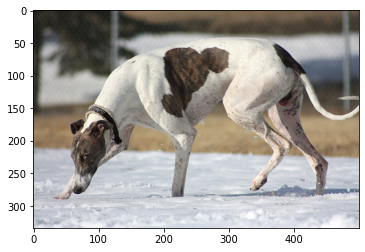

Greedy Search: a brown and white dog is running through a field
Beam Search, K = 3: a brown and white dog runs through the field
Beam Search, K = 5: a brown and white dog runs through the field
Beam Search, K = 7: a brown and white dog runs through the field
Beam Search, K = 10: a brown and white dog runs through the field


In [ ]:
pic = '3256043809_47258e0b3e.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beamSearch_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beamSearch_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beamSearch_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beamSearch_predictions(image, beam_index = 10))


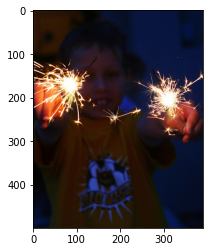

Greedy Search: a man in a blue shirt is standing in front of a large brown and white building
Beam Search, K = 3: a woman in a purple shirt is holding a piece of
Beam Search, K = 5: a girl in a purple shirt is holding a piece of
Beam Search, K = 7: a little girl in a pink shirt is holding a piece of chopsticks
Beam Search, K = 10: a little girl in a pink shirt eats a piece of bread


In [ ]:
pic = '747921928_48eb02aab2.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beamSearch_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beamSearch_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beamSearch_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beamSearch_predictions(image, beam_index = 10))

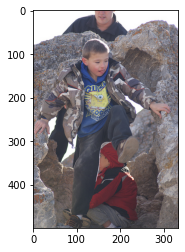

Greedy Search: a man in a red shirt climbing a rock
Beam Search, K = 3: a man in a red shirt climbing a rock
Beam Search, K = 5: a man climbing a rock
Beam Search, K = 7: a man climbing a rock
Beam Search, K = 10: a rock climber scales a steep rock cliff


In [ ]:
pic = '3119875880_22f9129a1c.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beamSearch_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beamSearch_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beamSearch_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beamSearch_predictions(image, beam_index = 10))

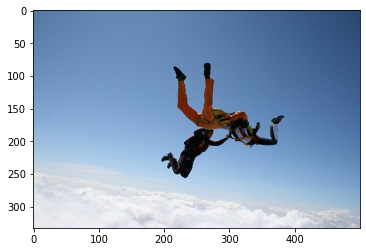

Greedy Search: a man in midair
Beam Search, K = 3: the bungee jumper into the air
Beam Search, K = 5: the bungee jumper into the air
Beam Search, K = 7: the bungee jumper into the air
Beam Search, K = 10: the bungee jumper into the air


In [ ]:
pic = '3339140382_2e49bc324a.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beamSearch_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beamSearch_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beamSearch_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beamSearch_predictions(image, beam_index = 10))

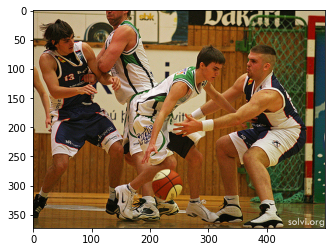

Greedy Search: a basketball player in a white uniform is trying to make a shot but the opposing team in the stadium
Beam Search, K = 3: the basketball player in white is the player in white for the ball
Beam Search, K = 5: the basketball player in white is the player in white for the ball
Beam Search, K = 7: the basketball player in white is the player in white for the ball in the field
Beam Search, K = 10: an opposing basketball player dribbles the ball during a game


In [ ]:
pic = '3072172967_630e9c69d0.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beamSearch_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beamSearch_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beamSearch_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beamSearch_predictions(image, beam_index = 10))

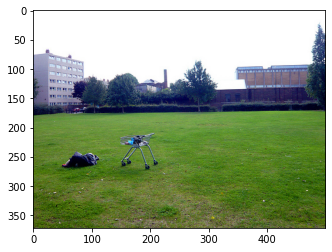

Greedy Search: a man in a red shirt is sitting on a bench with a bat
Beam Search, K = 3: a man and a woman are sitting on top of a wooden floor with many watching
Beam Search, K = 5: a little boy in a yellow shirt is sitting on top of a fake in a grassy field
Beam Search, K = 7: a little boy in a yellow shirt is sitting on top of a fake in a grassy field
Beam Search, K = 10: a little boy in a yellow shirt is sitting on top of a fake in a grassy field


In [ ]:
pic = '2854207034_1f00555703.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beamSearch_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beamSearch_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beamSearch_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beamSearch_predictions(image, beam_index = 10))

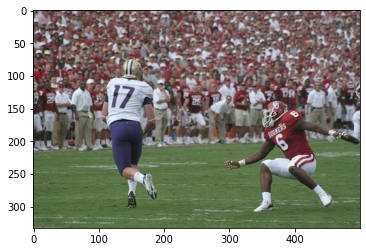

Greedy Search: a football player in a red jersey is tackling another player in white who is tackling the ball
Beam Search, K = 3: a football player in a red jersey is tackling another player in red who is running with the ball whilst fans watch
Beam Search, K = 5: three football players are tackling a football player in a red and white uniform
Beam Search, K = 7: an american footballer in a red and white uniform gets ready to tackle an opposing player
Beam Search, K = 10: an american footballer in a red and white uniform gets ready to tackle an opposing player while fans watch


In [ ]:
pic = '241346971_c100650320.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beamSearch_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beamSearch_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beamSearch_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beamSearch_predictions(image, beam_index = 10))

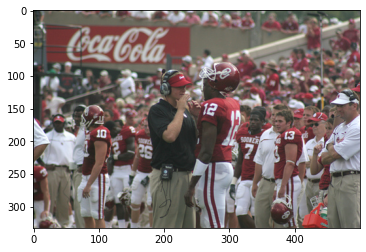

Greedy Search: a group of college people are standing in a line
Beam Search, K = 3: a group of football players are speaking to play
Beam Search, K = 5: a group of football players wearing red and white uniforms gather together
Beam Search, K = 7: a large group of football players are standing in front of a stadium
Beam Search, K = 10: a large group of football players run down a foggy field


In [ ]:
pic = '241345844_69e1c22464.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beamSearch_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beamSearch_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beamSearch_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beamSearch_predictions(image, beam_index = 10))

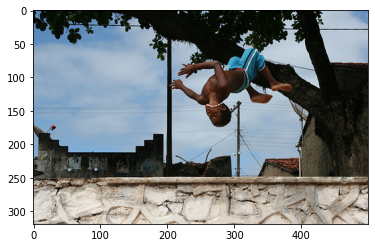

Greedy Search: a skateboarder uses a trick in midair
Beam Search, K = 3: a skateboarder uses a trick in midair
Beam Search, K = 5: a skateboarder uses a trick in midair
Beam Search, K = 7: a skateboarder uses a trick in midair
Beam Search, K = 10: a skateboarder uses a trick in midair


In [ ]:
pic = '2351479551_e8820a1ff3.jpg'
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Greedy Search:",greedySearch(image))
print("Beam Search, K = 3:",beamSearch_predictions(image, beam_index = 3))
print("Beam Search, K = 5:",beamSearch_predictions(image, beam_index = 5))
print("Beam Search, K = 7:",beamSearch_predictions(image, beam_index = 7))
print("Beam Search, K = 10:",beamSearch_predictions(image, beam_index = 10))

In [ ]:
file = open(test_path,'r').read()
test_token = list()
for line in file.split('\n'):
  if len(line) > 1:
    test_id = line.split('.')[0]
    test_token.append(test_id)
test = set(test_token)
print('Dataset: %d' % len(test))

Dataset: 1000


## Creating a Dictionary for mapping test tokens and model predictions

In [ ]:
test_result = dict()
for line in new_img_captions.split('\n'):
    tokens = line.split()
    image_id, image_caption  = tokens[0], tokens[1:]
    # print(image_id)
    # break
    if image_id in test:
      if image_id not in test_result:
        pic = image_id + '.jpg'
        image = encoding_test[pic].reshape((1,2048))
        test_result[image_id] = list()
        test_result[image_id].append(greedySearch(image))
        # test_result[image_id].append(beamSearch_predictions(image, beam_index = 3))

## Converting Dictionary to txt file

In [ ]:
def Greedy_result(dictionary, filename):
    lines = list()
    for token, caption in dictionary.items():
        for cap in caption:
            lines.append(token + '\t' + cap )
    data = "\n".join(lines)
    file = open(filename,"w")
    file.write(data)
    file.close()


In [ ]:
Greedy_result(test_result,'greedy_search1.txt')

## Evaluation Using BLEU Score


In [ ]:
import  nltk.translate.bleu_score as bleu

BLEU Score:  0.1990168886519548
BLEU Score:  0.23534372545921417
BLEU Score:  0.40981981728730915
BLEU Score:  0.40981981728730915
BLEU Score:  0.32069656099009686


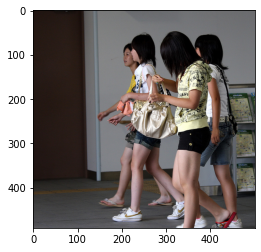

Caption-> four blackhaired girls in shorts are walking
Caption-> four girls in shorts walk down the street
Caption-> four little girls walking together
Caption-> there are four girls with shorts on walking together
Caption-> three girls wearing shorts walking
predicted caption by greedy search is:     a woman in a pink dress is holding a baby in a
predicted caption by beam search for k=3 is:     a young girl in a pink striped shirt is standing in front of a restaurant
predicted caption by beam search for k=5 is:     a little girl in a white dress is standing in front of the aqua
predicted caption by beam search for k=7 is:     a little girl in a white dress is standing in front of the aqua
predicted caption by beam search for k=10 is:     a little girl in a white dress is standing in front of a restaurant dancing


In [ ]:
 token = '3249891874_6a090ef097.jpg'
 image =  encoding_train[token].reshape((1,2048))
 reference = img_captions[token.split('.')[0]]
 candidate1 = greedySearch(image)
 candidate2 = beamSearch_predictions(image, beam_index = 3)
 candidate3 = beamSearch_predictions(image, beam_index = 5)
 candidate4 = beamSearch_predictions(image, beam_index = 7)
 candidate5 = beamSearch_predictions(image, beam_index = 10)
 print("BLEU Score: ",bleu.sentence_bleu(reference, candidate1))
 print("BLEU Score: ",bleu.sentence_bleu(reference, candidate2))
 print("BLEU Score: ",bleu.sentence_bleu(reference, candidate3))
 print("BLEU Score: ",bleu.sentence_bleu(reference, candidate4))
 print("BLEU Score: ",bleu.sentence_bleu(reference, candidate5))
 show_caption(token.split('.')[0],img_captions)
 print('predicted caption by greedy search is:    ', candidate1)
 print('predicted caption by beam search for k=3 is:    ', candidate2)
 print('predicted caption by beam search for k=5 is:    ', candidate3)
 print('predicted caption by beam search for k=7 is:    ', candidate4)
 print('predicted caption by beam search for k=10 is:    ', candidate5)

## Storing test results of Beam Search 

In [ ]:
Beam_result_dict = dict()
for line in new_img_captions.split('\n'):
    tokens = line.split()
    image_id, image_caption  = tokens[0], tokens[1:]
   
    if image_id in test:
      if image_id not in Beam_result_dict:
        pic = image_id + '.jpg'
        image = encoding_test[pic].reshape((1,2048))
        Beam_result_dict[image_id] = list()
        Beam_result_dict[image_id].append(beamSearch_predictions(image, beam_index = 7))

In [ ]:
Greedy_result(Beam_result_dict,'Beam_search.txt')

## Saving the modle Files

In [ ]:
json_file = model.to_json()
with open('/content/drive/MyDrive/DS303/model_store.json', "w") as file:
   file.write(json_file)
model.save_weights('/content/drive/MyDrive/DS303/model_weights.h5')